In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import random
from torchvision.utils import save_image
import os
from torch.optim.lr_scheduler import StepLR
import glob
import cv2
import math
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset

In [2]:
UNET_PATH = 'model_weight/unet_small.pth'
DNN_PATH = 'model_weight/dnn_small.pth'
num_epochs = 100
dnn_epoch = 300

# Hyperparameters
BATCH_SIZE = 256 
MNIST = True
CIFAR10 = False

# Network Training Settings
Train_BASE_DNN = True
Train_Unet = True

if (os.path.exists(DNN_PATH)) == True:
    Train_BASE_DNN = False

if (os.path.exists(UNET_PATH)) == True:
    Train_Unet = False

In [3]:
if (os.path.exists("./output")) == False:
    os.mkdir("output")

if (os.path.exists("./model_weight")) == False:
    os.mkdir("model_weight")

if (os.path.exists("./test_out")) == False:
    os.mkdir("test_out")

for epoch in range (num_epochs):
    if (os.path.exists("./output/%03d" % epoch)) == False:
        os.mkdir("./output/%03d" % epoch)
    else:
        files = glob.glob("./output/%03d/*.png" % epoch)

        for f in files:
          os.remove(f)

In [4]:
train_dataset = datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor()
                       ]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_dataset =  datasets.MNIST('data', train=False, transform=transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor()
                       ]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)


num_samples = int(len(train_dataset) * 0.03)
indices = np.random.choice(len(train_dataset), num_samples, replace=False)

train_dataset_small = Subset(train_dataset, indices)
train_loader = torch.utils.data.DataLoader(train_dataset_small, batch_size=BATCH_SIZE, shuffle=True)


9913344it [00:00, 30564207.46it/s]                             


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



29696it [00:00, 29762019.49it/s]         

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw




1649664it [00:00, 10767997.75it/s]                           


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



5120it [00:00, ?it/s]                   


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



# VGG

In [5]:
class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
dnn_criterion = nn.CrossEntropyLoss()

def dnn_test(dnn_model, test_loader):
    total = 0
    total_correct = 0
    test_loss = 0

    for i, (images, labels) in enumerate(test_loader):
        images = images.cuda()
        labels = labels.cuda()

        outputs = dnn_model(images)
        loss = dnn_criterion(outputs, labels)

        _, pred = torch.max(outputs, 1)
        correct = pred.eq(labels).cpu().sum().item()
        total_correct += correct
        total += labels.size(0)

        test_loss += loss.item()

    test_loss /= len(test_loader)

    return total_correct / total, test_loss

Training DNN classifier...
Epoch 10/300, acc: 0.11444444444444445 test_acc: 0.10286458333333333
Epoch 20/300, acc: 0.26722222222222225 test_acc: 0.24829727564102563
Epoch 30/300, acc: 0.45111111111111113 test_acc: 0.42127403846153844
Epoch 40/300, acc: 0.6044444444444445 test_acc: 0.6016626602564102
Epoch 50/300, acc: 0.6461111111111111 test_acc: 0.6469350961538461
Epoch 60/300, acc: 0.6627777777777778 test_acc: 0.6745793269230769
Epoch 70/300, acc: 0.6744444444444444 test_acc: 0.6813902243589743
Epoch 80/300, acc: 0.695 test_acc: 0.7204527243589743
Epoch 90/300, acc: 0.71 test_acc: 0.7013221153846154
Epoch 100/300, acc: 0.7144444444444444 test_acc: 0.7483974358974359
Epoch 110/300, acc: 0.7416666666666667 test_acc: 0.7528044871794872
Epoch 120/300, acc: 0.7677777777777778 test_acc: 0.7794471153846154
Epoch 130/300, acc: 0.7688888888888888 test_acc: 0.7896634615384616
Epoch 140/300, acc: 0.7927777777777778 test_acc: 0.8040865384615384
Epoch 150/300, acc: 0.805 test_acc: 0.8123998397435

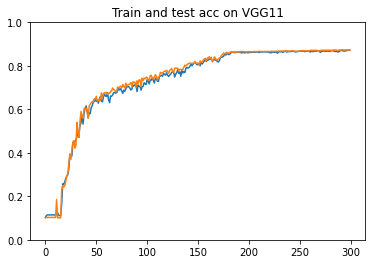

In [7]:
if (Train_BASE_DNN):
    dnn_model = VGG11().cuda()
    dnn_optimizer = torch.optim.Adam(dnn_model.parameters(), lr=1e-5)
    scheduler = StepLR(dnn_optimizer, step_size=180, gamma=0.1)

    print("Training DNN classifier...")
    acc_history = []
    test_acc_history = []
    for epoch in range(dnn_epoch):
        total = 0
        total_correct = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()

            # Forward pass
            outputs = dnn_model(images)
            loss = dnn_criterion(outputs, labels)

            # Backward pass and optimization
            dnn_optimizer.zero_grad()
            loss.backward()
            dnn_optimizer.step()

            _, pred = torch.max(outputs, 1)
            correct = pred.eq(labels).cpu().sum().item()
            total_correct += correct
            total += labels.size(0)

        acc_history.append(total_correct / total)
        test_acc_history.append(dnn_test(dnn_model, test_loader)[0])
    
        if((epoch + 1) % 10 == 0):
            print(f'Epoch {epoch + 1}/{dnn_epoch}', end = ', ')
            print('acc:',acc_history[-1], 'test_acc:', test_acc_history[-1])

        scheduler.step()
        
    print("DNN classifier training complete.")
    torch.save(dnn_model.state_dict(), DNN_PATH)

    plt.plot(range(0, dnn_epoch), acc_history)
    plt.plot(range(0, dnn_epoch), test_acc_history)
    plt.ylim(0, 1)
    plt.title("Train and test acc on VGG11")

In [8]:
dnn_model = VGG11().cuda()
dnn_criterion = nn.CrossEntropyLoss()
dnn_model.load_state_dict(torch.load(DNN_PATH))

print("Testing DNN classifier...")

test_acc, test_loss = dnn_test(dnn_model, test_loader)

print("Test Acc:" , test_acc)
print("DNN classifier Test complete.")

Testing DNN classifier...
Test Acc: 0.8723958333333334
DNN classifier Test complete.


# Unet

In [9]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.activate = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(p=0.5)
        self.sigmod = nn.Sigmoid ()
        self.label_embedding = nn.Embedding(10, 512)

        self.encoder_1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding= 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding= 1),
            nn.ReLU(inplace=True),
        )

        self.encoder_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding= 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding= 1),
            nn.ReLU(inplace=True),
        )

        self.encoder_3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding= 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding= 1),
            nn.ReLU(inplace=True),
        )

        self.encoder_4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding= 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding= 1),
            nn.ReLU(inplace=True),
        )
        
        self.middle_1_0 = nn.Conv2d(1024, 1024, 3, padding= 1)
        self.middle_1_1 = nn.Conv2d(1024, 1024, 3, padding= 1)
        
       
        self.deconv4_0 = nn.ConvTranspose2d(1536, 512, 3, stride=(2,2), padding = 1, output_padding = 1)
        self.uconv4_1 = nn.Conv2d(1024, 512, 3, padding= 1) 
        self.uconv4_2 = nn.Conv2d(512, 512, 3, padding= 1)

        self.deconv3_0 = nn.ConvTranspose2d(512, 512, 3, stride=(2,2), padding = 1, output_padding = 1)
        self.uconv3_1 = nn.Conv2d(768, 256, 3, padding= 1) 
        self.uconv3_2 = nn.Conv2d(256, 256, 3, padding= 1)

        self.deconv2_0 = nn.ConvTranspose2d(256, 512, 3, stride=(2,2), padding = 1, output_padding = 1)
        self.uconv2_1 = nn.Conv2d(640, 128, 3, padding= 1) 
        self.uconv2_2 = nn.Conv2d(128, 128, 3, padding= 1)

        self.deconv1_0 = nn.ConvTranspose2d(128, 512, 3, stride=(2,2), padding = 1, output_padding = 1)
        self.uconv1_1 = nn.Conv2d(576, 192, 3, padding= 1) 
        self.uconv1_2 = nn.Conv2d(192, 192, 3, padding= 1)

  
        self.out_layer = nn.Conv2d(192, 1, 1)

 

    def forward(self, x, input_labels, target_labels):
        conv1 = self.encoder_1(x)
        pool1 = self.pool(conv1)
        pool1 = self.dropout(pool1)

        conv2 = self.encoder_2(pool1)
        pool2 = self.pool(conv2)
        pool2 = self.dropout(pool2)

        conv3 = self.encoder_3(pool2)
        pool3 = self.pool(conv3)
        pool3 = self.dropout(pool3)

        conv4 = self.encoder_4(pool3)
        pool4 = self.pool(conv4)
        encoder_out = self.dropout(pool4)

        input_label_embedding = self.label_embedding(input_labels).view(input_labels.size(0), 512, 1, 1)
        x1 = torch.cat([encoder_out, input_label_embedding.expand_as(encoder_out)], dim=1)

        convm = self.middle_1_0(x1)
        convm = self.activate(convm)
        convm = self.middle_1_1(convm)
        x2 = self.activate(convm)

        target_label_embedding = self.label_embedding(target_labels).view(target_labels.size(0), 512, 1, 1)
        x2 = torch.cat([x2, target_label_embedding.expand(x2.size(0), 512, x2.size(2), x2.size(3))], dim=1)

        deconv4 = self.deconv4_0(x2)
        uconv4 = torch.cat([deconv4, conv4], 1)   # (None, 4, 4, 1024)
        uconv4 = self.dropout(uconv4)
        uconv4 = self.uconv4_1(uconv4)            # (None, 4, 4, 512)
        uconv4 = self.activate(uconv4)
        uconv4 = self.uconv4_2(uconv4)            # (None, 4, 4, 512)
        uconv4 = self.activate(uconv4)

        deconv3 = self.deconv3_0(uconv4)          # (None, 8, 8, 512)
        uconv3 = torch.cat([deconv3, conv3], 1)   # (None, 8, 8, 768)
        uconv3 = self.dropout(uconv3)
        uconv3 = self.uconv3_1(uconv3)            # (None, 8, 8, 256)
        uconv3 = self.activate(uconv3)
        uconv3 = self.uconv3_2(uconv3)            # (None, 8, 8, 256)
        uconv3 = self.activate(uconv3)
        
        deconv2 = self.deconv2_0(uconv3)          # (None, 16, 16, 512)
        uconv2 = torch.cat([deconv2, conv2], 1)   # (None, 16, 16, 640)
        uconv2 = self.dropout(uconv2)
        uconv2 = self.uconv2_1(uconv2)            # (None, 16, 16, 128)
        uconv2 = self.activate(uconv2)
        uconv2 = self.uconv2_2(uconv2)            # (None, 16, 16, 128)
        uconv2 = self.activate(uconv2)

        deconv1 = self.deconv1_0(uconv2)          # (None, 32, 32, 512)
        uconv1 = torch.cat([deconv1, conv1], 1)   # (None, 32, 32, 576)
        uconv1 = self.dropout(uconv1)
        uconv1 = self.uconv1_1(uconv1)            # (None, 32, 32, 192)
        uconv1 = self.activate(uconv1)
        uconv1 = self.uconv1_2(uconv1)            # (None, 32, 32, 192)
        uconv1 = self.activate(uconv1)

        out = self.out_layer(uconv1)
        out = self.sigmod(out)

        return out

In [10]:
def perceptual_loss(vgg_model, input_images, output_images):
    feature_layers = [vgg_model.features[i] for i in range(len(vgg_model.features))]
    feature_extractor = nn.Sequential(*feature_layers[:-1]).cuda()
    
    input_features = feature_extractor(input_images)
    output_features = feature_extractor(output_images)
    
    return nn.functional.mse_loss(input_features, output_features)



def generate_synthetic_digits(digit, count):
    all_digit_indices = np.where(train_dataset_small.dataset.targets.cpu() == digit.cpu())[0]
    digit_indices = np.intersect1d(all_digit_indices, indices)
    
    if len(digit_indices) == 0:
        raise ValueError(f"No samples found for label {digit.item()}")
        
    selected_indices = np.random.choice(digit_indices, count, replace=True)
    synthetic_digits = torch.stack([train_dataset[i][0] for i in selected_indices])
    return synthetic_digits

vgg = models.vgg16(pretrained=True).features.eval().cuda()

# Function to extract features for a batch of images using the VGG model
def extract_features(images):
    with torch.no_grad():
        features = vgg(images)
    return features.view(images.size(0), -1)


def find_nearest_neighbor(images, target_labels, target_label, synthetic_target_digits):
    target_images = synthetic_target_digits
    target_images = target_images[target_labels == target_label]

    # Convert the MNIST images to 3-channel format for VGG model
    images_3channel = images.repeat(1, 3, 1, 1)
    target_images_3channel = target_images.repeat(1, 3, 1, 1)

    # Extract features for input images and target_images
    input_features = extract_features(images_3channel)
    target_features = extract_features(target_images_3channel)

    # Compute distances between input_features and target_features
    input_features_expanded = input_features.unsqueeze(1)
    target_features_expanded = target_features.unsqueeze(0)

    # Compute distances between input images and target_images
    distances = (input_features_expanded - target_features_expanded).view(images.size(0), target_images.size(0), -1).norm(dim=2)

    # Find the index of the input image with the smallest distance to the selected target_image
    min_distances, min_indices = distances.min(dim=1)
    closest_input_image_index = min_indices[min_distances.argmin()]

    return target_images[min_indices[closest_input_image_index]]


def compare_histograms(images1, images2, images3, epoch, i):
    images1_flat = images1.reshape(-1)
    images2_flat = images2.reshape(-1)
    images3_flat = images3.reshape(-1)
    
    plt.figure()
    plt.hist(images1_flat, bins=10, alpha=0.5, label='Original Images')
    plt.hist(images2_flat, bins=10, alpha=0.5, label='Target Images')
    plt.hist(images3_flat, bins=10, alpha=0.5, label='Reconstructed Images')
    plt.legend(loc='upper right')
    plt.savefig("./output/%03d/%04d_dist.png" % ( epoch, i))
    plt.close()

Epoch 1/100
Step [1/8], loss: 14.98035 recon loss: 6.848361492156982 dnn loss: 2.835958480834961 loss on loss: 5.270732 p_loss: 0.025296970456838607
Step [5/8], loss: 14.023055 recon loss: 6.657155752182007 dnn loss: 2.5806210041046143 loss on loss: 4.7600565 p_loss: 0.025222210586071013
Epoch 2/100
Step [1/8], loss: 13.159458 recon loss: 6.172463893890381 dnn loss: 2.453493595123291 loss on loss: 4.505802 p_loss: 0.02769855335354805
Step [5/8], loss: 14.128986 recon loss: 10.083266496658325 dnn loss: 1.4572504758834839 loss on loss: 2.5133157 p_loss: 0.07515440583229065
Epoch 3/100
Step [1/8], loss: 10.035078 recon loss: 5.019923448562622 dnn loss: 1.791674017906189 loss on loss: 3.1821628 p_loss: 0.04131819605827331
Step [5/8], loss: 9.863311 recon loss: 4.5425331592559814 dnn loss: 1.8919503688812256 loss on loss: 3.3827155 p_loss: 0.04611224681138992
Epoch 4/100
Step [1/8], loss: 9.691787 recon loss: 5.863784551620483 dnn loss: 1.3871885538101196 loss on loss: 2.3731918 p_loss: 0.0

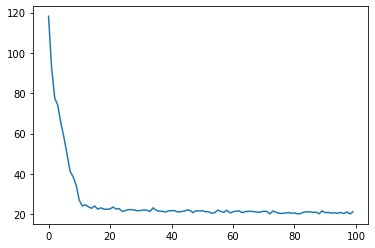

In [11]:
# Training loop
if (Train_Unet):
    # Initialize model, loss, and optimizer
    model = UNet().cuda()
    dnn_model = VGG11().cuda()
    dnn_model.load_state_dict(torch.load(DNN_PATH))
    dnn_criterion = nn.CrossEntropyLoss()

    # Freeze the DNN classifier weights
    for param in dnn_model.parameters():
        param.requires_grad = False

    # Hyperparameters
    alpha, beta = 0.5, 0.3

    learning_rate = 1e-4
    step_size = 60
    gamma = 0.1

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    loss_history = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        epoch_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()

            target_labels = (labels + torch.randint(1, 9, size=(labels.size(0),)).cuda()) % 10

            outputs = model(images, labels, target_labels)
            
            # Generate target images (same digit as target labels)
            # eroded_images = erode_images(images)
            synthetic_target_digits = torch.cat([generate_synthetic_digits(d, 1) for d in target_labels]).cuda()

            # Generate target images (same digit as target labels)
            target_images = images.clone()
            for j in range(labels.size(0)):
               target_images[j] = find_nearest_neighbor(images, target_labels, target_labels[j], synthetic_target_digits)

            # Compute reconstruction loss
            reconstruction_loss = criterion(outputs, target_images)

            # Train the classifier on the reconstructed images
            classifier_outputs = dnn_model(outputs)
            classification_loss = dnn_criterion(classifier_outputs, target_labels)
            loss_on_loss = torch.abs(test_loss - classification_loss)
            p_loss = perceptual_loss(dnn_model, images, outputs)

            # Total loss
            total_loss = 10 * reconstruction_loss + alpha * classification_loss + beta * p_loss + loss_on_loss
            epoch_loss += total_loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if (i ) % 4 == 0:
                print(f'Step [{i + 1}/{len(train_loader)}]', end = ', ')
                print('loss:' , total_loss.data.cpu().numpy(), 
                      'recon loss:', 10 * reconstruction_loss.data.cpu().numpy(), 
                      'dnn loss:', alpha * classification_loss.data.cpu().numpy(),
                      'loss on loss:', loss_on_loss.data.cpu().numpy(),
                      'p_loss:', beta * p_loss.data.cpu().numpy())
                
                save_image(outputs.data, './output/%03d/%04d_recon.png' % ( epoch, i))
                save_image(images.data, './output/%03d/%04d_img.png' % ( epoch, i))
                save_image(target_images.data, './output/%03d/%04d_target.png' % ( epoch, i))

                # Convert the images to NumPy arrays
                images_np = images.cpu().numpy()
                target_images_np = target_images.cpu().numpy()
                reconstructed_images_np = outputs.detach().cpu().numpy()

                compare_histograms(images_np, target_images_np, reconstructed_images_np, epoch, i)

        loss_history.append(epoch_loss)
        scheduler.step()

    torch.save(model.state_dict(), UNET_PATH)
    plt.plot(range(0, num_epochs), loss_history)

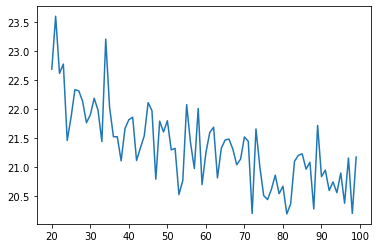

In [12]:
plt.plot(range(20, num_epochs), loss_history[20:])

# Testing

In [13]:
def generate_augmented_test_images(model, test_loader, num_augmented_images=1000):
    augmented_images = []
    augmented_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda()
            labels = labels.cuda()

            target_labels = (labels + torch.randint(1, 9, size=(labels.size(0),)).cuda()) % 10
            outputs = model(images, labels, target_labels)
            
            augmented_images.append(outputs.cpu())
            augmented_labels.append(target_labels.cpu())
            
            if len(augmented_images) * labels.size(0) >= num_augmented_images:
                break
    
    augmented_images = torch.cat(augmented_images)[:num_augmented_images]
    augmented_labels = torch.cat(augmented_labels)[:num_augmented_images]
    
    return augmented_images, augmented_labels

augmented_test_images, augmented_test_labels = generate_augmented_test_images(model, test_loader)


In [14]:
resized_train_images = torch.stack([train_dataset_small.dataset[i][0] for i in indices])
    
train_images = torch.cat([resized_train_images, augmented_test_images])
train_labels = torch.cat([torch.tensor(train_dataset_small.dataset.targets )[indices], augmented_test_labels])

C:\Users\55366\AppData\Local\Temp\ipykernel_15284\3042864789.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.cat([torch.tensor(train_dataset_small.dataset.targets )[indices], augmented_test_labels])


In [15]:
train_dataset_extended = TensorDataset(train_images, train_labels)
train_loader_extended = DataLoader(train_dataset_extended, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [16]:
dnn_model = VGG11().cuda()  # Define your classifier (e.g., a CNN)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=1e-5)
scheduler = StepLR(dnn_optimizer, step_size=180, gamma=0.1)

# Training loop for the new classifier
acc_history_1 = []
test_acc_history_1 = []
for epoch in range(dnn_epoch):
    total_correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader_extended):
        images = images.cuda()
        labels = labels.cuda()

        # Forward pass
        outputs = dnn_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = torch.max(outputs, 1)
        correct = pred.eq(labels).cpu().sum().item()
        total_correct += correct
        total += labels.size(0)
    

    if((epoch + 1 )% 10 == 0):
        print(f'Epoch {epoch + 1}/{dnn_epoch}', end = ', ')
        print('acc:',acc_history_1[-1], 'test_acc:', test_acc_history_1[-1])
    acc_history_1.append(total_correct / total)
    test_acc_history_1.append(dnn_test(dnn_model, test_loader)[0])
    scheduler.step()

c:\Users\55366\anaconda3\envs\ml\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 10/300, acc: 0.10859375 test_acc: 0.10286458333333333
Epoch 20/300, acc: 0.7234375 test_acc: 0.6368189102564102
Epoch 30/300, acc: 0.789453125 test_acc: 0.706229967948718
Epoch 40/300, acc: 0.832421875 test_acc: 0.7474959935897436
Epoch 50/300, acc: 0.859765625 test_acc: 0.7740384615384616
Epoch 60/300, acc: 0.86796875 test_acc: 0.8010817307692307
Epoch 70/300, acc: 0.888671875 test_acc: 0.8148036858974359
Epoch 80/300, acc: 0.89765625 test_acc: 0.8376402243589743
Epoch 90/300, acc: 0.90859375 test_acc: 0.8465544871794872
Epoch 100/300, acc: 0.91015625 test_acc: 0.859375
Epoch 110/300, acc: 0.92578125 test_acc: 0.8722956730769231
Epoch 120/300, acc: 0.932421875 test_acc: 0.8769030448717948
Epoch 130/300, acc: 0.93984375 test_acc: 0.8824118589743589
Epoch 140/300, acc: 0.946484375 test_acc: 0.8897235576923077
Epoch 150/300, acc: 0.954296875 test_acc: 0.8860176282051282
Epoch 160/300, acc: 0.96015625 test_acc: 0.8950320512820513
Epoch 170/300, acc: 0.963671875 test_acc: 0.903645833

(0.0, 1.0)

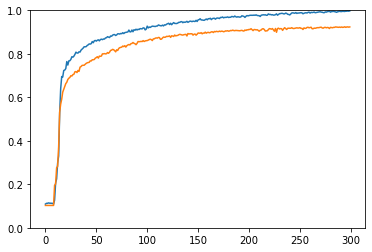

In [17]:
plt.plot(range(0, dnn_epoch), acc_history_1)
plt.plot(range(0, dnn_epoch), test_acc_history_1)
plt.ylim(0, 1)

(0.0, 1.0)

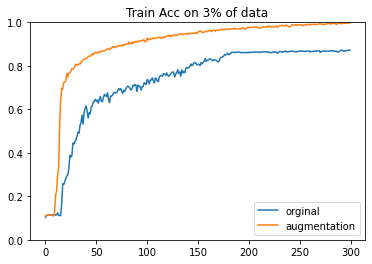

In [27]:
plt.plot(range(0, dnn_epoch), acc_history)
plt.plot(range(0, dnn_epoch), acc_history_1)
plt.title("Train Acc on 3% of data")
plt.legend(['orginal', 'augmentation'])


plt.ylim(0, 1)

(0.0, 1.0)

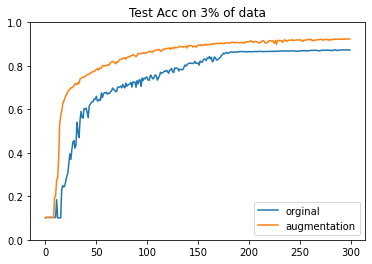

In [28]:
plt.plot(range(0, dnn_epoch), test_acc_history)
plt.plot(range(0, dnn_epoch), test_acc_history_1)
plt.title("Test Acc on 3% of data")
plt.legend(['orginal', 'augmentation'])
plt.ylim(0, 1)

# Unet Recon Img 

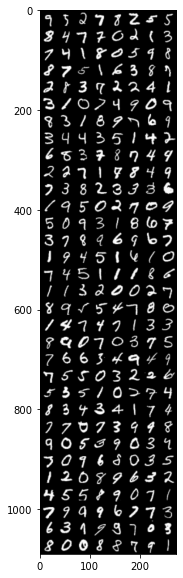

In [20]:
image = plt.imread('./output/%03d/0000_img.png'% (num_epochs -1))
plt.figure(figsize = (10,10))
plt.imshow(image)

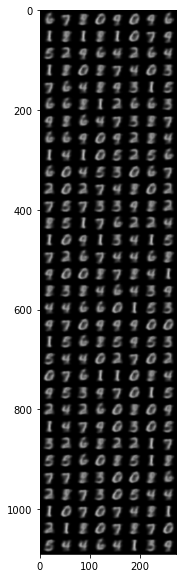

In [21]:
image = plt.imread('./output/%03d/0000_recon.png'% (num_epochs -1))
plt.figure(figsize = (10,10))
plt.imshow(image)

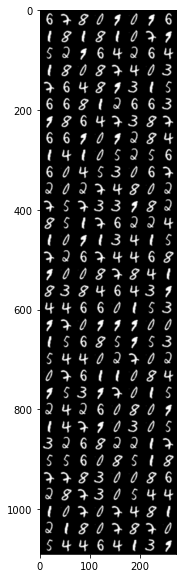

In [22]:
image = plt.imread('./output/%03d/0000_target.png'% (num_epochs -1))
plt.figure(figsize = (10,10))
plt.imshow(image)

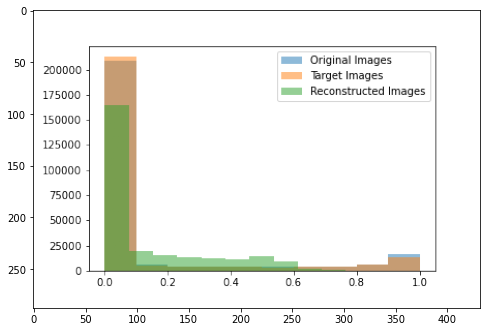

In [23]:
image = plt.imread('./output/%03d/0000_dist.png'% (num_epochs -1))
plt.figure(figsize = (8,8))
plt.imshow(image)

In [26]:
import pandas as pd

d = {'train': acc_history, 'train_aug': acc_history_1, 'test': test_acc_history, 'test_aug': test_acc_history_1}
df = pd.DataFrame(d)

df.to_csv('./acc.csv')